<a href="https://colab.research.google.com/github/ibader85/UnstructuredDataAnalytics/blob/main/06_Introduction_to_Topic_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

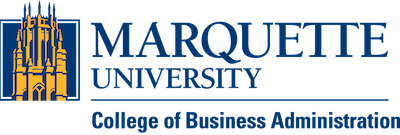

#BUAN4060: Unstructured Data Analytics

##06 Introdcution To Topic Modeling

##Instructor: Dr. Badar Al Lawati "Dr. B"

**Acknowledgment:** This material is based on the content created by `Prof. Timothy E. Carone`

**R on Colab:**

* You can change the runtime from Python to R, by clicking on the down arrow next to Connect, and picking "Change Runtime Type"

* You can change the project name by clicking on the title on top of this page

* You can export your notebook by going to File > Download .ipynb



## 1. Introdcution

Natural Language Processing (usually shortened to “NLP”) is the task of automatically extracting and summarizing information from text data

There are many different tasks in NLP and this tutorial will focus on just one of them: topic modeling. (There are some links at the end of this lesson to other tutorials for doing common NLP tasks in R.)

> ###  **Topic modeling:** The NLP task of identifying automatically identifying major themes in a text, usually by identifying informative words

There are two main uses for topic modeling. The first is to help in identifying major topics in unlabeled texts. You can think of it as a replacement for word clouds to help you understand the recurring themes in a text

The second use is to identify which words are important for text that is labeled for topic. In this tutorial we’ll practice both kinds of topic modeling

##2. Setting up our workspace

Before we can get started on topic modelling, we need to get our environment set up. First, let’s load in the packages we’re going to use. Here, I’ve added a comment letting you know why we need each package

In [19]:
system2('sudo', 'apt-get install libgsl0-dev')

In [20]:
# read in the libraries we're going to use
install.packages("tidyverse") # designed to make data manipulation, visualization, and analysis more user-friendly
install.packages("tidytext") # provides functions for tokenizing, counting words, and analyzing text data in a structured manner
install.packages("tm") # provides functions for text preprocessing, term-document matrix creation, and text mining tasks.
install.packages("topicmodels") # used for topic modeling, which is a technique to uncover latent topics within a collection of documents
install.packages("SnowballC") # for stemming


library(tidyverse) # general utility & workflow functions
library(tidytext) # tidy implimentation of NLP methods
library(tm) # general text mining functions, making document term matrixes
library(topicmodels)  # used for topic modeling, which is a technique to uncover latent topics within a collection of documents
library(SnowballC) # for stemming

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



Now let’s read in our data. For this tutorial we’re going to be using a corpus of hotel reviews put together by Myle Ott and co-authors. It contains positive and negative hotel reviews

Some are real reviews written by actual customers, while others are fake deceptive reviews. For more details, check out this paper on this dataset:

In [21]:
# read in our data
reviews <- read_csv("deceptive-opinion.csv")

Rows: 1600 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): deceptive, hotel, polarity, source, text

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## 3. Unsupervised topic modeling with LDA

Latent Dirichlet allocation, more commonly shortened to LDA, is one unsupervised way of doing topic modeling

> ## **Unsupervised**: In machine learning, a problem is unsupervised if you don’t have labeled examples of the thing you’re trying to figure out

LDA rests on the assumption that each document is going to have some subset of topics in it, and that each topic is associated with a certain subset of words. Imagine, for example, that you have three text ads:

- One is for Chow-Chow Crunch, a new dog food
- One is for Danny’s Downhome Diner, a new restaurant
- One is for Fifi’s Chic Puppy Boutique, a store that sells dog accessories

Both the diner and the dog food ad will probably have words associated with the topic of food in them, like “tasty”, “filling” or “delicious”. Both the dog food and the pet store will probably have words associated with the topic of pets, like “canine”, “pet” or “owner”. And, because they’re all ads, it likely that all three documents will have words associated with advertising in them, like “sale”, “price” or “special”

The tricky part is that words can also belong to more than one topic. I just said that “special” could be associated with advertising… but it can also be associated with food, especially in terms like “blue plate special” or “chef’s special”

What LDA outputs, then, is two estimates:

1. An estimate of how much each topic contributes to each document
2. An estimate of how much each word contributes to each topic

For exploratory analysis, especially if you have a large number of documents, the second estimate is usually more interesting

In order to make our lives easier (since we’re going to ran an LDA several times) let’s write a function that takes a text column from a data frame and returns a plot of the most informative words for a given number of topics

In [22]:
# function to get & plot the most informative terms by a specificed number of topics, using LDA
top_terms_by_topic_LDA <- function(input_text, # should be a columm from a dataframe
                                   plot = T, # return a plot? TRUE by defult
                                   number_of_topics = 4) # number of topics (4 by default)
{
    # create a corpus (type of object expected by tm) and document term matrix
    Corpus <- Corpus(VectorSource(input_text)) # make a corpus object
    DTM <- DocumentTermMatrix(Corpus) # get the count of words/document

    # remove any empty rows in our document term matrix (if there are any
    # we'll get an error when we try to run our LDA)
    unique_indexes <- unique(DTM$i) # get the index of each unique value
    DTM <- DTM[unique_indexes,] # get a subset of only those indexes

    # preform LDA & get the words/topic in a tidy text format
    lda <- LDA(DTM, k = number_of_topics, control = list(seed = 1234))
    topics <- tidy(lda, matrix = "beta")

    # get the top ten terms for each topic
    top_terms <- topics  %>% # take the topics data frame and..
      group_by(topic) %>% # treat each topic as a different group
      top_n(10, beta) %>% # get the top 10 most informative words
      ungroup() %>% # ungroup
      arrange(topic, -beta) # arrange words in descending informativeness

    # if the user asks for a plot (TRUE by default)
    if(plot == T){
        # plot the top ten terms for each topic in order
        top_terms %>% # take the top terms
          mutate(term = reorder(term, beta)) %>% # sort terms by beta value
          ggplot(aes(term, beta, fill = factor(topic))) + # plot beta by theme
          geom_col(show.legend = FALSE) + # as a bar plot
          facet_wrap(~ topic, scales = "free") + # represent each topic in a seperate plot
          labs(x = NULL, y = "Beta") + # no x label, change y label
          coord_flip() # turn bars sideways
    }else{
        # if the user does not request a plot
        # return a list of sorted terms instead
        return(top_terms)
    }
}

Alright, now let’s try out our function on our dataset!

> ### **But how do we know how many topics we should have?** You can’t be sure ahead of time unless you’re very familiar with the dataset and know how many topics you expect to see. Probably the most common way to figure out how many topics there are automatically is to train a lot of different models with different numbers of topics and then see which has the least uncertainty (generally measured by perplexity). This can be a bit resource-intensive, especially if you have a large corpus, so I’m not going to cover it in detail here. You can check out this [guide](https://info5940.infosci.cornell.edu/#perplexity) for more details if you’re curious

Since I know that this dataset contains deceptive and truthful reviews, I’m going to specify that I want to know about two topics

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘plyr’



Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths




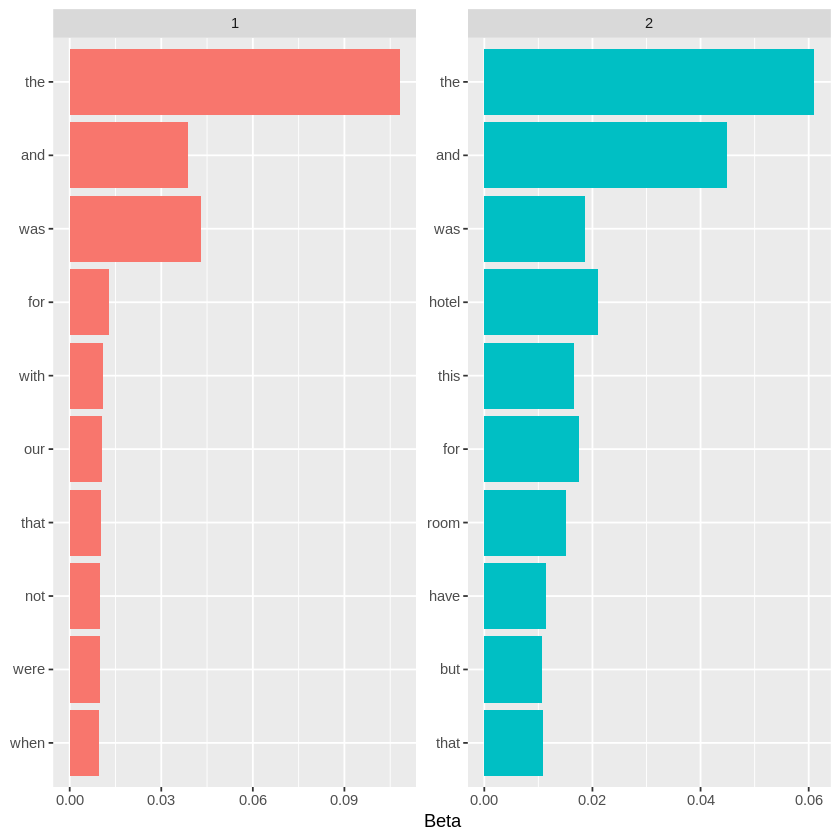

In [24]:
install.packages("reshape2")
library(reshape2)

# plot top ten terms in the hotel reviews by topic
top_terms_by_topic_LDA(reviews$text, number_of_topics = 2)

These topics aren’t actually very interesting or informative. This is because they include a lot of very common words that play important grammatical roles but don’t actually convey a lot of information

Our topic modelling will be a lot more useful if we remove these words

##4. Pre-processing text for more informative models

In the last section, we tried our hand at topic modelling uisng LDA and found that our models were not very informative becuase they had a lot of very common stopwords in them

> ### **Stopwords**: Words that are very commonly used in a language but are not very informative. Examples of English stopwords include “the”, “of” and “and”. These are often removed during NLP tasks using a hand-curated list. We have stopword lists for many languages on Kaggle, including this one which has stopword lists for 19 languages

Let’s see if our topics are any more interesting if we try pre-processing our text data to remove stopwords. (I’m also going to remove both “hotel” and “room”, where are very common in hotel reviews.)

In [25]:
# create a document term matrix to clean
reviewsCorpus <- Corpus(VectorSource(reviews$text))
reviewsDTM <- DocumentTermMatrix(reviewsCorpus)

# convert the document term matrix to a tidytext corpus
reviewsDTM_tidy <- tidy(reviewsDTM)

# I'm going to add my own custom stop words that I don't think will be
# very informative in hotel reviews
custom_stop_words <- tibble(word = c("hotel", "room"))

# remove stopwords
reviewsDTM_tidy_cleaned <- reviewsDTM_tidy %>% # take our tidy dtm and...
    anti_join(stop_words, by = c("term" = "word")) %>% # remove English stopwords and...
    anti_join(custom_stop_words, by = c("term" = "word")) # remove my custom stopwords

# reconstruct cleaned documents (so that each word shows up the correct number of times)
cleaned_documents <- reviewsDTM_tidy_cleaned %>%
    group_by(document) %>%
    mutate(terms = toString(rep(term, count))) %>%
    select(document, terms) %>%
    unique()

# check out what the cleaned documents look like (should just be a bunch of content words)
# in alphabetic order
head(cleaned_documents)

document,terms
<chr>,<chr>
1,"173, 44in, 7th, aaa, adults, bathroom(no, beat, bose, breakfast, chicago..., complete, concierge, evian, family, fine, flaw, floor, food, friday, gem, getaway, gorgeous, heartbeat., helpful., kids, location..., morning), night, plasma, pricey, rate, restaurant., return, service, slow(2hours, stayed, steal., stereo,, tables, thursday., triple, tub, us), voss, wait., water,, worth"
2,"$200, attractions, bed., bldg., bldg., breakfast, comfortable, distance., included, lake,, major, rate, restaurants,, river,, shopping,, sightseeing, tribune, triple, upgrade, view, view, vouchers., walking, wrigley"
3,"$100, (however,, 2007, attractions., bears, bit, bother, busier, cabs, cabs, car, catching, check, check, chicago, chicago, chicago,, city., clean,, clubing, comfortable, convenient, day,, dear, dinner, division, downright, downtown, easy, expensive, finally, friend, friend, friends, homegame, hotel., hotel., hotwire,, husband, hyatt, hyatt, imo., late, late, left, lovely,, months:), morning,, night, october, out., parking,, past, perfect,, pretty, public, quality, quickly, rate, regency, reviews, st.., stayed, steal, sunday, think)., time, town., traffic, transportation, usual, usual, views, visiting"
4,"'standard', address, all,, avenue., cardio, center, check, chicago, chicago, chicago., cramped, delivers, delivers., desk., dining, equipment., events,, feel, fitness, free, fronts,, helpful, largest, level, living, location, machines,, michigan, minutes,, omni, omni, people, plentiful, price, prized, property!, quality,, range, recommendations, requires, rows, separate, shared, spaciousness, staff, staff, way!, weight, weights,"
5,"avenue, center, clean., decorated,, district., elevator, equipped, fitness, floor, functional, got., location, lot, michigan, order., pleasant, pleasantly, prompt., service, shopping"
6,"(no, (the, 676,, 676,, absolutely, air, amazing, amenities, anything., bar, bartender, bathroom, business, checked, checked, chicago, comfy, complaint, completely, concierge, day, difference., dispose, doorman,, downtown, efficiently, entire, freshener, heavy, hotel!!, hotel., housekeeping,, impressed, in., kleenex/coffee, managed, manager, meeting, negative, night, night, omni, omni, outstanding., paraphernalia., personnel, problem), require, scent, service;, sink, sitting, stay, stay!, stay),, stayed, stays,, suffice, superior., thanks,, tiny, waited, waiter, walk, wastebasket, wastebasket, wet, windows."


OK, that’s our preprocessing is complete, let’s check out our new (hopefully more informative) topic models

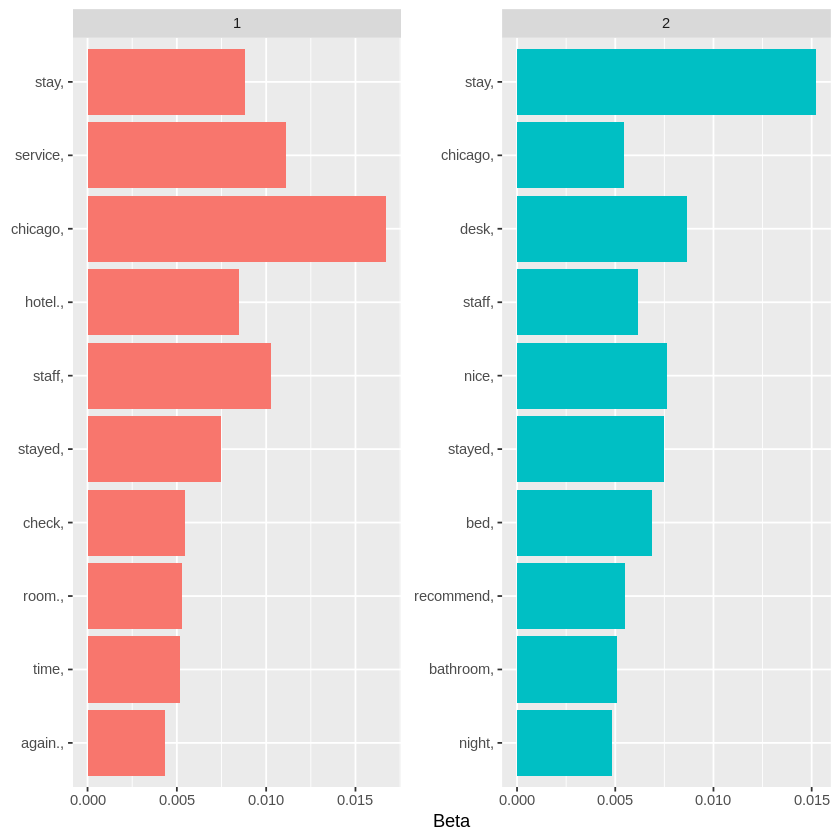

In [26]:
# now let's look at the new most informative terms
top_terms_by_topic_LDA(cleaned_documents$terms, number_of_topics = 2)

As you can see, these are much more helpful! We can now tell the difference between these topics. While they appear pretty similar (which isn’t surprising given that there’s a limited number of topics we’d expect to see discussed in hotel reviews) it looks like the first topic is more about people’s stay and the second topic is more about the city of Chicago

This isn’t too surprising, since all of the hotels reviewed were in Chicago and it’s a major tourist destination

You may notice something about these topics, however. In the just the first ten words we see a little bit of repetition. Topic one contains both “stay” and “stayed”

This is a little bit less informative than it could be, because “stay” and “stayed” are different forms of the same underlying word. We can collapse all the different forms of the same word with a process called “stemming”

> ### **Stemming**: Removing all the inflection from words. For instance, the root form of “horses”, “horse”, and “horsing [around]” is the same word: “horse”. For some NLP tasks, we want to count all of these words as the same word

Let’s try our LDA topic modeling again, this time after stemming our data

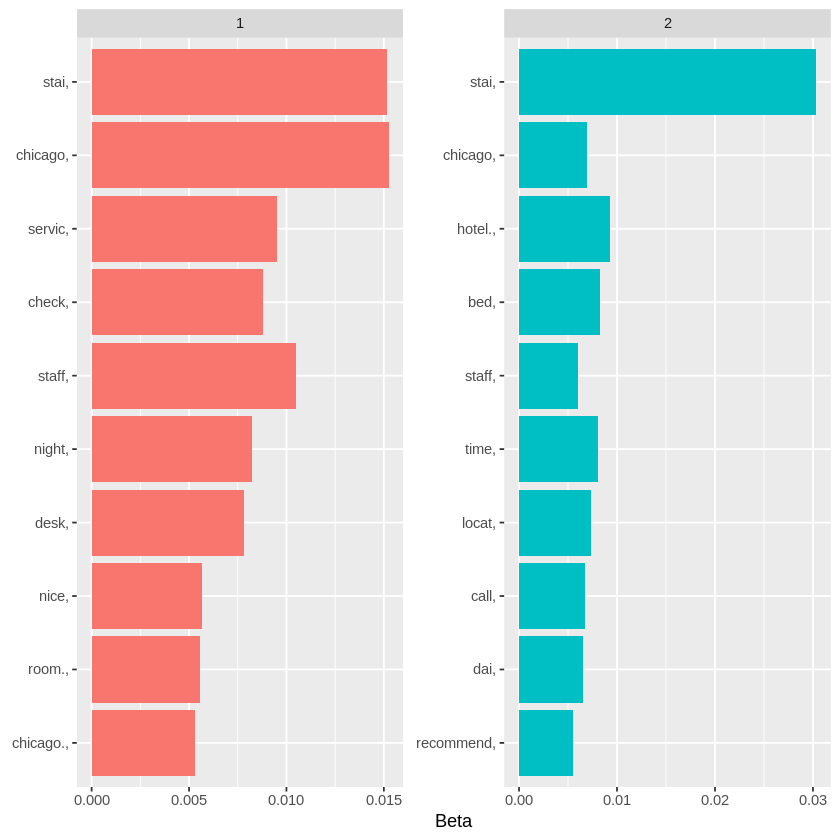

In [27]:
# stem the words (e.g. convert each word to its stem, where applicable)
reviewsDTM_tidy_cleaned <- reviewsDTM_tidy_cleaned %>%
    mutate(stem = wordStem(term))

# reconstruct our documents
cleaned_documents <- reviewsDTM_tidy_cleaned %>%
    group_by(document) %>%
    mutate(terms = toString(rep(stem, count))) %>%
    select(document, terms) %>%
    unique()

# now let's look at the new most informative terms
top_terms_by_topic_LDA(cleaned_documents$terms, number_of_topics = 2)

> ### **What’s up with the weird looking words look weird, like “locat” and “stai”?** These are the stems of the words, which in this case are generated using the [Porter Stemming Algorithm](https://tartarus.org/martin/PorterStemmer/). If we look at our “horse” example above, the stem of “horses”, “horse”, and “horsing [around]” is actually “hors”, not “horse”. That’s because “hors” is the longest string that occurs in all three words

In this instance, it doesn’t actually look like stemming was actually that helpful in terms of generating informative topics. We also don’t know which (if either) of these topics are associated with deceptive reviews and which are associated with truthful ones.

Fortunately, we actually do have the labels for whether each review is truthful or deceptive, which means that we can use a supervised method of topic modeling instead

In general, unsupervised methods (like LDA) are helpful for data exploration but supervised methods (like TF-IDF, which we’re going to learn next) are usually a better choice if you have access to labeled data

We’ve started with ab unsupervised method here in order to give you the chance to directly compare LDA and TF-IDF on the same dataset.

## 5. Supervised topic modeling with TF-IDF

Now that we’ve given unsupervised topic modelling a go, let’s try supervised topic modeling. For this, we’re going to use something call TF-IDF, which stands for “term frequency-inverse document frequency”.

The general idea behind how TF-IDF works is this:

- Words that are very common in a specific document are probably important to the topic of that document
- Words that are very common in all documents probably aren’t important to the topics of any of them

So a term will recieve a high weight if it’s common in a specific document and also uncommon across all documents

In order to streamline our analysis, I’m going to write a function that takes in a dataframe, the name of the column that has the texts in it and the name of the column that has the topic labels in it

In [28]:
# function that takes in a dataframe and the name of the columns
# with the document texts and the topic labels. If plot is set to
# false it will return the tf-idf output rather than a plot.
top_terms_by_topic_tfidf <- function(text_df, text_column, group_column, plot = T){
    # name for the column we're going to unnest_tokens_ to
    # (you only need to worry about enquo stuff if you're
    # writing a function using using tidyverse packages)
    group_column <- enquo(group_column)
    text_column <- enquo(text_column)

    # get the count of each word in each review
    words <- text_df %>%
      unnest_tokens(word, !!text_column) %>%
      count(!!group_column, word) %>%
      ungroup()

    # get the number of words per text
    total_words <- words %>%
      group_by(!!group_column) %>%
      summarize(total = sum(n))

    # combine the two dataframes we just made
    words <- left_join(words, total_words)

    # get the tf_idf & order the words by degree of relevence
    tf_idf <- words %>%
      bind_tf_idf(word, !!group_column, n) %>%
      select(-total) %>%
      arrange(desc(tf_idf)) %>%
      mutate(word = factor(word, levels = rev(unique(word))))

    if(plot == T){
        # convert "group" into a quote of a name
        # (this is due to funkiness with calling ggplot2
        # in functions)
        group_name <- quo_name(group_column)

        # plot the 10 most informative terms per topic
        tf_idf %>%
          group_by(!!group_column) %>%
          top_n(10) %>%
          ungroup %>%
          ggplot(aes(word, tf_idf, fill = as.factor(group_name))) +
          geom_col(show.legend = FALSE) +
          labs(x = NULL, y = "tf-idf") +
          facet_wrap(reformulate(group_name), scales = "free") +
          coord_flip()
    }else{
        # return the entire tf_idf dataframe
        return(tf_idf)
    }
}

Now that we’ve done that, we can quickly and easily check out the most informative words for truthful and deceptive reviews

Joining with `by = join_by(deceptive)`
Selecting by tf_idf


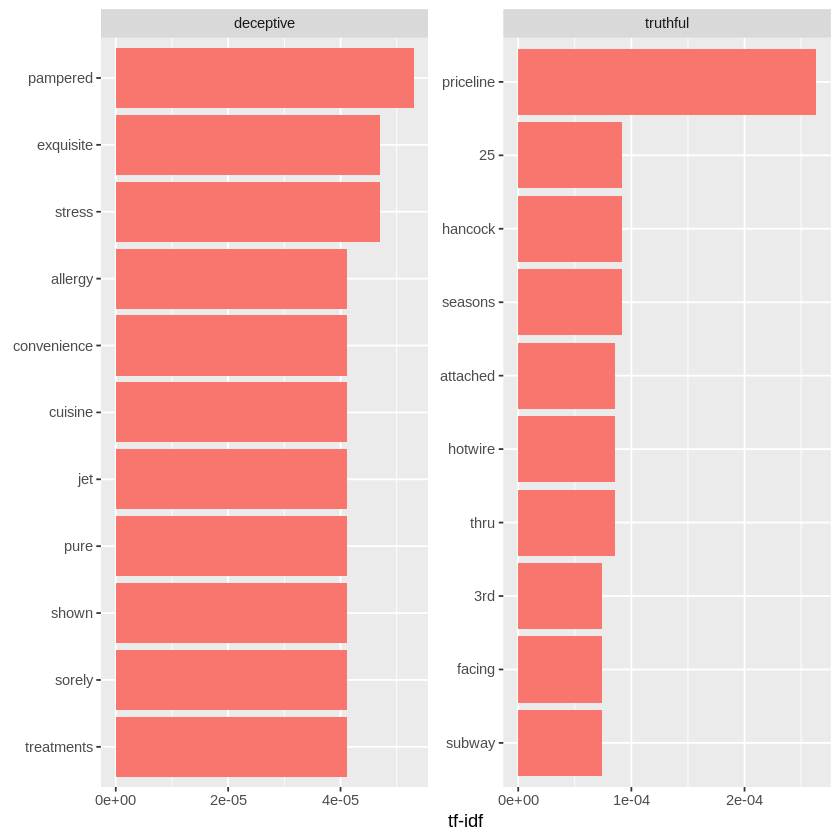

In [29]:
# let's see what our most informative deceptive words are
top_terms_by_topic_tfidf(text_df = reviews, # dataframe
                         text_column = text, # column with text
                         group_column = deceptive, # column with topic label
                         plot = T) # return a plot

Interesting! So it looks like false reviews tend to use a lot of glowing praise in their reviews (“pampered”, “exquisite”), while truthful reviews tend to talk about how they booked thier room (“priceline”, “hotwire”)

Since we have a function written, we can easily check out the most informative words for other topics. This dataset is also annotated for whether the reveiw was positive or negative, so let’s see which words are associated with which polarity

Joining with `by = join_by(polarity)`
Selecting by tf_idf


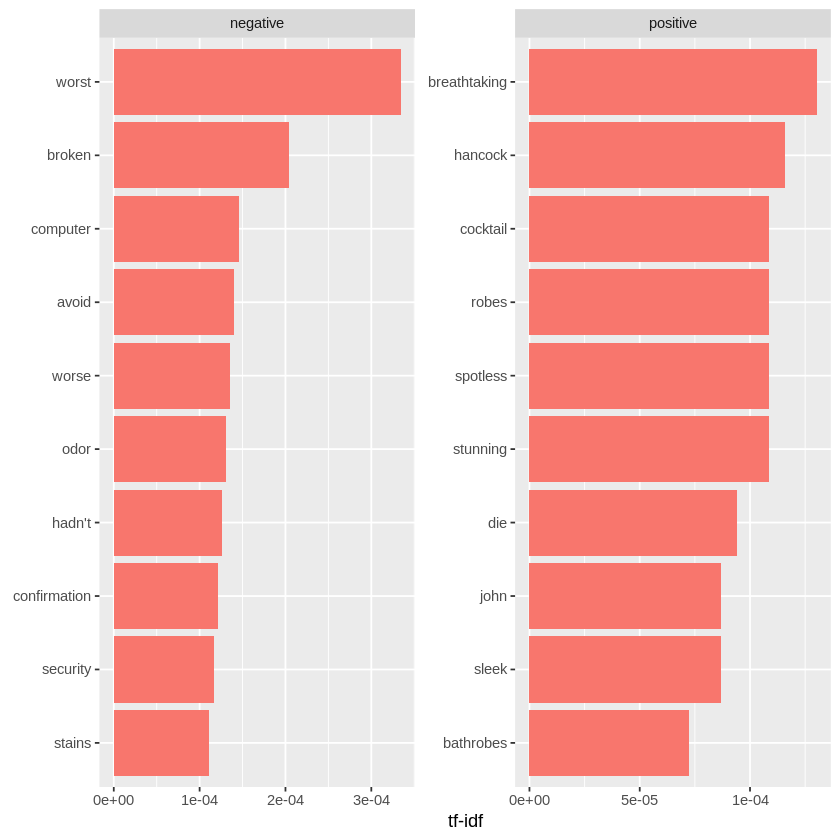

In [30]:
# look for the most informative words for postive and negative reveiws
top_terms_by_topic_tfidf(text_df = reviews,
                         text_column = text,
                         group = polarity,
                         plot = T)

From this, we can see that negative reviews include words like “worst”, “broken”, “odor” and “stains”, while positive reviews really harp on the bathrobes (both “robes” and “bathrobes” show up in the top ten words)

Just for fun/as a sanity check, let’s check out the reviews for each hotel individually. I’m going to use the function I wrote above to return just the TF-IDF output and then do my own plotting, since I don’t think the default plot will look good with so many different categories (there are 20 different hotels in this dataset)

Joining with `by = join_by(hotel)`
Selecting by tf_idf


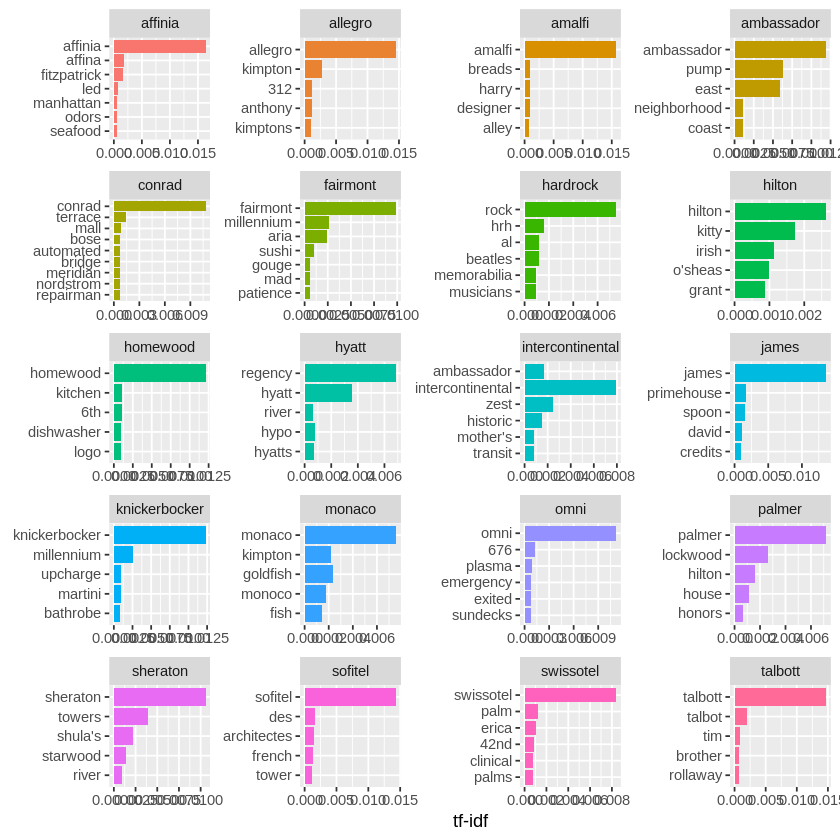

In [31]:
# get just the tf-idf output for the hotel topics
reviews_tfidf_byHotel <- top_terms_by_topic_tfidf(text_df = reviews,
                         text_column = text,
                         group = hotel,
                         plot = F)

# do our own plotting
reviews_tfidf_byHotel  %>%
          group_by(hotel) %>%
          top_n(5) %>%
          ungroup %>%
          ggplot(aes(word, tf_idf, fill = hotel)) +
          geom_col(show.legend = FALSE) +
          labs(x = NULL, y = "tf-idf") +
          facet_wrap(~hotel, ncol = 4, scales = "free", ) +
          coord_flip()

Unsurprisingly, the most informative word for reviews about a hotel is the name of the hotel itself

We can also tell a little bit about the features of different hotels: the Monaco has goldfish, Homewood has a kitchen with a dishwasher and Hardrock has musical memorabilia